In [1]:
!pip install -q imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.combine import SMOTEENN
import joblib

In [3]:
df = pd.read_csv("DiabetesDataSurveyBy_RIR.csv")

In [4]:
gender_encoder = LabelEncoder()
df['gender'] = gender_encoder.fit_transform(df['gender'])

In [5]:
X = df.drop(columns=['output'])
y = df['output']

In [6]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [8]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=10,
    max_samples=0.7,
    class_weight='balanced',
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

In [9]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, max_samples=0.7,
                       min_samples_leaf=10, n_estimators=300, n_jobs=-1,
                       oob_score=True, random_state=42)

In [10]:
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

In [11]:
print("Train Accuracy:", round(accuracy_score(y_train, train_preds) * 100, 2), "%")
print("Test Accuracy:", round(accuracy_score(y_test, test_preds) * 100, 2), "%")
print("OOB Score:", round(rf.oob_score_ * 100, 2), "%")

Train Accuracy: 98.0 %
Test Accuracy: 97.78 %
OOB Score: 97.44 %


In [12]:
print("Classification Report (Test):")
print(classification_report(y_test, test_preds))

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       107
           1       0.96      1.00      0.98       118

    accuracy                           0.98       225
   macro avg       0.98      0.98      0.98       225
weighted avg       0.98      0.98      0.98       225



In [13]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))

Confusion Matrix:
[[102   5]
 [  0 118]]


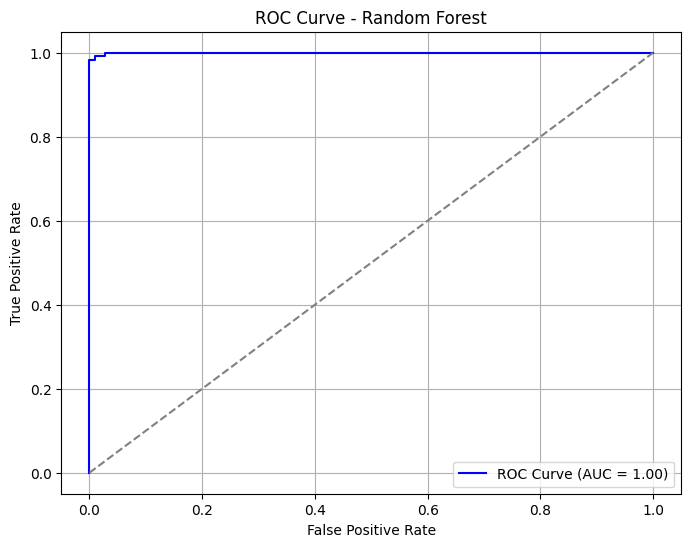

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test_probs = rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

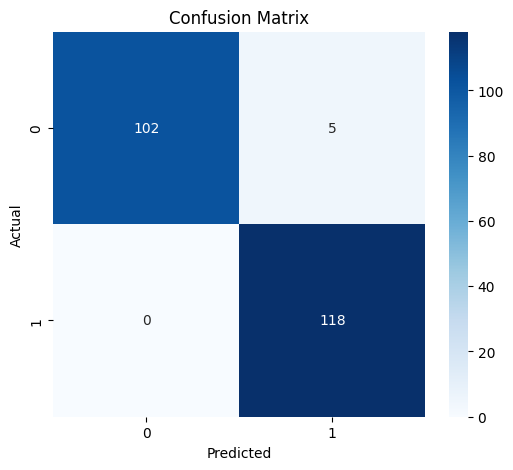

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [16]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X_resampled, y_resampled, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Std Dev:", np.std(cv_scores))

Cross-Validation Accuracy Scores: [0.96888889 0.98666667 0.98666667 0.96888889 0.96444444]
Mean CV Accuracy: 0.9751111111111112
Std Dev: 0.009573626323794682


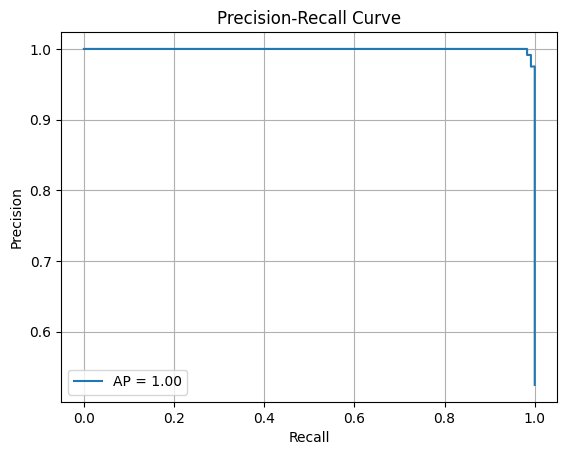

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

probs = rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
avg_prec = average_precision_score(y_test, probs)

plt.figure()
plt.plot(recall, precision, label=f"AP = {avg_prec:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
print("Co-relation Series")
correlation = df.corr()
print(correlation['output'].sort_values(ascending=False))

Co-relation Series
output                    1.000000
glucose                   0.537416
family_diabetes           0.460467
bmi                       0.326550
cardiovascular_disease    0.208347
weight                    0.178559
stroke                    0.124627
diastolic_bp              0.037740
pluse_rate                0.010257
age                      -0.058757
systolic_bp              -0.097535
height                   -0.219434
gender                   -0.353175
Name: output, dtype: float64
